# 01.3 Confounding: The Tablets Example

**Chapter**: 1 - Introduction to Causality  
**Section**: 3 - Confounding Example  
**Facure Source**: 01-Introduction-To-Causality.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Tablets-Tuition Story](#11-the-tablets-tuition-story)
   - 1.2 [What is Confounding?](#12-what-is-confounding)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Confounding as Common Cause](#21-confounding-as-common-cause)
   - 2.2 [Eliminating Confounding](#22-eliminating-confounding)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Simulating Confounded Data](#31-simulating-confounded-data)
   - 3.2 [Visualizing Confounding](#32-visualizing-confounding)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy.special import expit
import seaborn as sns

set_notebook_style()
np.random.seed(123)

---

## 1. Facure's Intuition

> **Interview Relevance**: Confounding is the most common threat to causal inference. You must be able to identify confounders and explain why they bias estimates.

### 1.1 The Tablets-Tuition Story

Facure's central example: **Do tablets in schools improve test scores?**

Observed pattern: Schools with tablets have higher ENEM scores.

**But wait**: Schools with tablets are also *wealthier* (higher tuition). Wealthy schools have:
- Better teachers
- More resources  
- Students from advantaged backgrounds

The observed association conflates:
1. The causal effect of tablets (if any)
2. The effect of wealth (confounding)

### 1.2 What is Confounding?

A **confounder** is a variable that:
1. Affects *both* treatment and outcome
2. Is NOT on the causal pathway from treatment to outcome

In the tablets example:
- **Tuition** (wealth) → **Tablet adoption** (wealthy schools buy tablets)
- **Tuition** (wealth) → **Test scores** (wealth improves scores)

```
        Tuition
       /       \
      v         v
   Tablet ---?--> Score
```

★ Insight ─────────────────────────────────────
- Confounding creates **backdoor paths** between T and Y
- The association picks up both the causal effect AND the backdoor
- Solution: "close" the backdoor by conditioning on the confounder
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Confounding as Common Cause

Let $C$ be a confounder. The causal structure is:

$$C \to T \quad \text{and} \quad C \to Y$$

This creates a **backdoor path**: $T \leftarrow C \to Y$

**Without conditioning on C**:
$$E[Y|T=1] - E[Y|T=0] = \underbrace{\text{Causal Effect}}_{T \to Y} + \underbrace{\text{Confounding Bias}}_{T \leftarrow C \to Y}$$

**Mathematical formulation**:

Under confounding, potential outcomes depend on $C$:
- $E[Y_0|T=1] \neq E[Y_0|T=0]$ because $C$ differs between groups
- The bias term in our decomposition is non-zero

### 2.2 Eliminating Confounding

**Strategy 1: Randomization**

If $T$ is randomly assigned, it's independent of $C$:
$$T \perp C \implies T \perp Y_0, Y_1$$

The backdoor path is severed by design.

**Strategy 2: Conditioning (Adjustment)**

Condition on the confounder:
$$E[Y|T=1, C=c] - E[Y|T=0, C=c]$$

Within strata of $C$, treatment is "as good as random" (if no other confounders).

**Conditional exchangeability assumption**:
$$Y_0, Y_1 \perp T | C$$

If this holds:
$$E[Y_1 - Y_0 | C=c] = E[Y|T=1, C=c] - E[Y|T=0, C=c]$$

And the overall ATE:
$$\text{ATE} = \sum_c E[Y_1 - Y_0 | C=c] \cdot P(C=c)$$

---

## 3. Numeric Demonstration

### 3.1 Simulating Confounded Data

In [2]:
# Facure's simulation: Tablets, Tuition, and ENEM scores
np.random.seed(123)
n = 500

# Confounder: Tuition (proxy for wealth)
tuition = np.random.normal(1000, 300, n).round()

# Treatment: Tablet adoption (depends on tuition)
# Higher tuition → higher probability of tablets
p_tablet = expit((tuition - tuition.mean()) / tuition.std())
tablet = np.random.binomial(1, p_tablet).astype(bool)

# Outcome: ENEM score
# True effect of tablets: -50 (negative!)
# Effect of tuition: +0.7 per dollar
enem_score = 200 - 50 * tablet + 0.7 * tuition + np.random.normal(0, 100, n)
enem_score = (enem_score - enem_score.min()) / (enem_score.max() - enem_score.min()) * 1000

data = pd.DataFrame({
    'enem_score': enem_score,
    'tuition': tuition,
    'tablet': tablet
})

print("Simulated Data (Facure's DGP)")
print("="*50)
print(f"Sample size: n = {n}")
print(f"Treatment rate: {tablet.mean():.1%}")
print(f"True treatment effect: -50 (tablets HURT scores)")
print(f"\nData preview:")
print(data.head(10).to_string())

Simulated Data (Facure's DGP)
Sample size: n = 500
Treatment rate: 47.6%
True treatment effect: -50 (tablets HURT scores)

Data preview:
   enem_score   tuition  tablet
0    305.2226  674.0000    True
1    595.9792 1299.0000    True
2    537.4946 1085.0000   False
3    416.8311  548.0000   False
4    465.6118  826.0000   False
5    793.2852 1495.0000   False
6    225.5577  272.0000   False
7    563.4937  871.0000   False
8    690.8529 1380.0000    True
9    332.1650  740.0000   False


In [3]:
# Show that tablet adoption depends on tuition (confounding)
print("EVIDENCE OF CONFOUNDING")
print("="*50)
print("\nMean tuition by tablet status:")
print(data.groupby('tablet')['tuition'].mean().round(1))
print(f"\nDifference: ${data.query('tablet')['tuition'].mean() - data.query('~tablet')['tuition'].mean():.1f}")
print("\nSchools with tablets have MUCH higher tuition!")

EVIDENCE OF CONFOUNDING

Mean tuition by tablet status:
tablet
False    851.9000
True    1138.6000
Name: tuition, dtype: float64

Difference: $286.7

Schools with tablets have MUCH higher tuition!


In [4]:
# Naive comparison (ignoring confounding)
naive_effect = data.query('tablet')['enem_score'].mean() - \
               data.query('~tablet')['enem_score'].mean()

print("NAIVE ANALYSIS (Ignoring Confounding)")
print("="*50)
print(f"E[Score | Tablet=1] = {data.query('tablet')['enem_score'].mean():.1f}")
print(f"E[Score | Tablet=0] = {data.query('~tablet')['enem_score'].mean():.1f}")
print(f"\nNaive 'effect' = {naive_effect:+.1f}")
print(f"True effect    = -50")
print(f"\nConclusion: Naive estimate is WRONG (even wrong sign!)")

NAIVE ANALYSIS (Ignoring Confounding)
E[Score | Tablet=1] = 592.3
E[Score | Tablet=0] = 470.1

Naive 'effect' = +122.2
True effect    = -50

Conclusion: Naive estimate is WRONG (even wrong sign!)


### 3.2 Visualizing Confounding

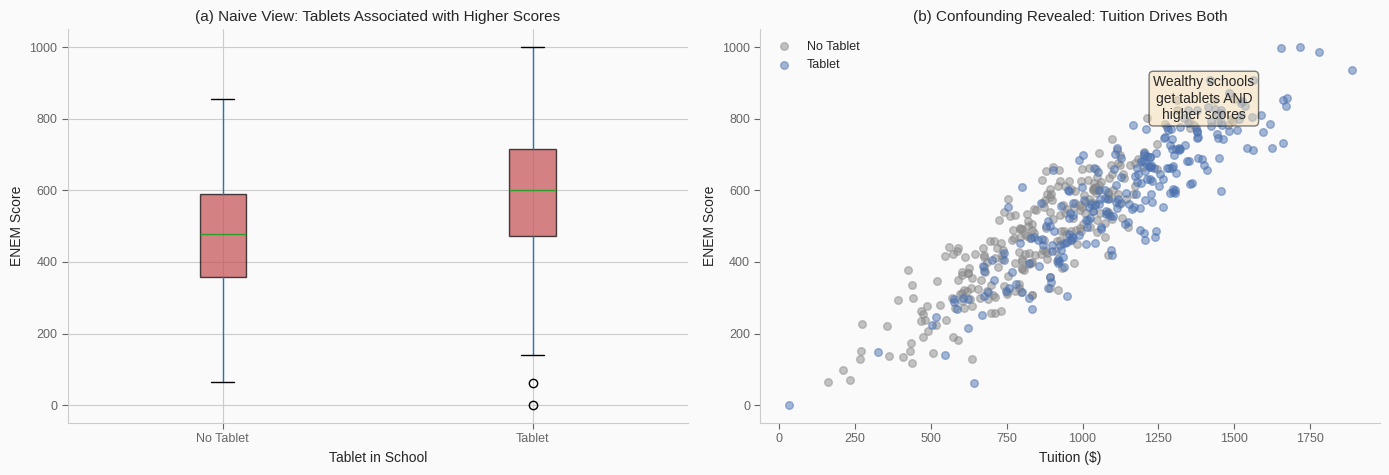

In [5]:
# Facure's key visualization: ENEM by Tuition, colored by Tablet
fig, axes = create_tufte_figure(1, 2, figsize=(14, 5))

# Panel 1: Box plot (naive view)
ax = axes[0]
data.boxplot('enem_score', by='tablet', ax=ax, 
             patch_artist=True,
             boxprops=dict(facecolor=TUFTE_PALETTE['effect'], alpha=0.7))
ax.set_xlabel('Tablet in School')
ax.set_ylabel('ENEM Score')
ax.set_title('(a) Naive View: Tablets Associated with Higher Scores')
ax.set_xticklabels(['No Tablet', 'Tablet'])
plt.suptitle('')  # Remove automatic title

# Panel 2: Scatter plot revealing confounding
ax = axes[1]
for tablet_val, label, color in [(False, 'No Tablet', TUFTE_PALETTE['control']),
                                  (True, 'Tablet', TUFTE_PALETTE['treatment'])]:
    subset = data.query(f'tablet == {tablet_val}')
    ax.scatter(subset['tuition'], subset['enem_score'], 
               alpha=0.5, label=label, color=color, s=30)

ax.set_xlabel('Tuition ($)')
ax.set_ylabel('ENEM Score')
ax.set_title('(b) Confounding Revealed: Tuition Drives Both')
ax.legend(frameon=False)

# Add annotation
ax.annotate('Wealthy schools\nget tablets AND\nhigher scores', 
            xy=(1400, 800), fontsize=10, ha='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [6]:
# Controlling for the confounder via regression
import statsmodels.formula.api as smf

# Model without control
model_naive = smf.ols('enem_score ~ tablet', data=data).fit()

# Model with control for tuition
model_adjusted = smf.ols('enem_score ~ tablet + tuition', data=data).fit()

print("REGRESSION ANALYSIS")
print("="*60)
print("\nModel 1: Y ~ Tablet (no controls)")
print(f"  Tablet coefficient: {model_naive.params['tablet[T.True]']:+.2f}")
print(f"  95% CI: [{model_naive.conf_int().loc['tablet[T.True]', 0]:.2f}, "
      f"{model_naive.conf_int().loc['tablet[T.True]', 1]:.2f}]")

print("\nModel 2: Y ~ Tablet + Tuition (controlling for confounder)")
print(f"  Tablet coefficient: {model_adjusted.params['tablet[T.True]']:+.2f}")
print(f"  95% CI: [{model_adjusted.conf_int().loc['tablet[T.True]', 0]:.2f}, "
      f"{model_adjusted.conf_int().loc['tablet[T.True]', 1]:.2f}]")

print("\nTrue effect: -50")
print(f"\nControlling for tuition moves estimate toward truth!")

REGRESSION ANALYSIS

Model 1: Y ~ Tablet (no controls)
  Tablet coefficient: +122.22
  95% CI: [92.63, 151.82]

Model 2: Y ~ Tablet + Tuition (controlling for confounder)
  Tablet coefficient: -40.46
  95% CI: [-55.51, -25.41]

True effect: -50

Controlling for tuition moves estimate toward truth!


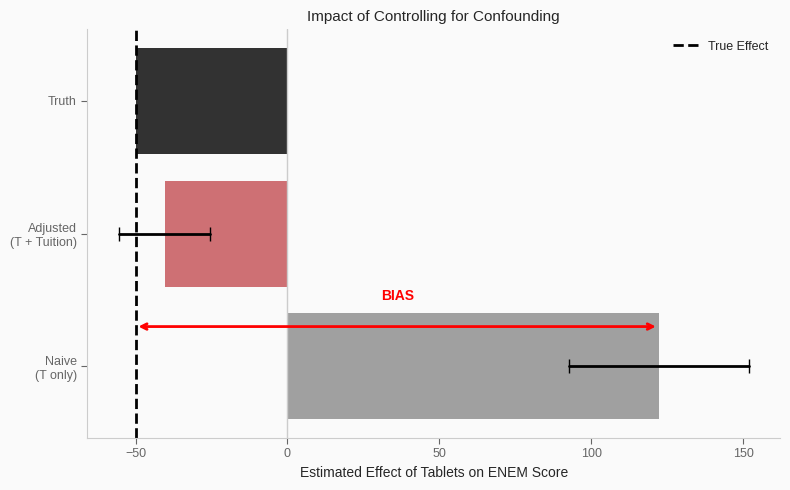

In [7]:
# Visualize the effect of controlling for confounding
fig, ax = create_tufte_figure(1, 1, figsize=(8, 5))

estimates = pd.DataFrame({
    'Method': ['Naive\n(T only)', 'Adjusted\n(T + Tuition)', 'Truth'],
    'Effect': [model_naive.params['tablet[T.True]'],
               model_adjusted.params['tablet[T.True]'],
               -50],
    'CI_low': [model_naive.conf_int().loc['tablet[T.True]', 0],
              model_adjusted.conf_int().loc['tablet[T.True]', 0],
              -50],
    'CI_high': [model_naive.conf_int().loc['tablet[T.True]', 1],
               model_adjusted.conf_int().loc['tablet[T.True]', 1],
               -50]
})

colors = [TUFTE_PALETTE['secondary'], TUFTE_PALETTE['effect'], 'black']
ax.barh(estimates['Method'], estimates['Effect'], color=colors, alpha=0.8)
ax.axvline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
ax.axvline(-50, color='black', linestyle='--', linewidth=2, label='True Effect')

# Add error bars for first two
for i in range(2):
    ax.plot([estimates.iloc[i]['CI_low'], estimates.iloc[i]['CI_high']], 
            [i, i], 'k-', linewidth=2)
    ax.plot([estimates.iloc[i]['CI_low']], [i], 'k|', markersize=10)
    ax.plot([estimates.iloc[i]['CI_high']], [i], 'k|', markersize=10)

ax.set_xlabel('Estimated Effect of Tablets on ENEM Score')
ax.set_title('Impact of Controlling for Confounding')
ax.legend(frameon=False)

# Annotate bias
ax.annotate('', xy=(model_naive.params['tablet[T.True]'], 0.3),
            xytext=(-50, 0.3),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text((model_naive.params['tablet[T.True]'] - 50)/2, 0.5, 
        'BIAS', color='red', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

---

## 4. Implementation

Detecting and adjusting for confounding is central to the `causal_inference_mastery` library:

```python
# Covariate balance check
from causal_inference.diagnostics import balance_check

balance = balance_check(
    covariates=data[['tuition']],
    treatment=data['tablet']
)
print(balance.summary())  # Shows SMD > 0.1 → imbalance

# Regression adjustment
from causal_inference.observational import regression_adjustment

result = regression_adjustment(
    outcome=data['enem_score'],
    treatment=data['tablet'],
    covariates=data[['tuition']]
)
print(f"Adjusted ATE: {result.ate:.2f}")
```

**Key methods for confounding**:
- Chapter 5: Regression adjustment
- Chapter 10-11: Matching and propensity scores
- Chapter 8: Instrumental variables (for unmeasured confounding)
- Chapter 13: Difference-in-differences (with parallel trends)

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Stripe Staff, DS)**: *"What is a confounder and how do you identify one?"*

<details>
<summary>Solution</summary>

**Definition**: A confounder is a variable that:
1. Causes (or is associated with) the treatment
2. Causes (or is associated with) the outcome
3. Is NOT on the causal path from treatment to outcome

**Identification strategies**:

1. **Domain knowledge**: Use subject matter expertise to identify plausible confounders
   - What variables affect both treatment and outcome?
   - Draw a causal DAG

2. **Data checks**:
   - Check if covariate differs between treatment groups (necessary but not sufficient)
   - Check if covariate predicts outcome in control group

3. **Backdoor criterion** (Pearl):
   - A set of variables is sufficient to control confounding if it blocks all backdoor paths
   - Requires knowing the causal structure

**Caution**: 
- A variable that differs between groups is NOT automatically a confounder
- Don't control for mediators (variables on the causal path)
- Don't control for colliders (variables caused by both T and Y)

</details>

---

**Q2 (Lyft Staff, Applied Scientist)**: *"In an observational study, how do you decide what variables to control for?"*

<details>
<summary>Solution</summary>

**Framework: The Backdoor Criterion**

1. **Draw a DAG** (Directed Acyclic Graph) representing your causal assumptions

2. **Identify backdoor paths**: Paths from T to Y that start with an arrow INTO T

3. **Block backdoor paths**: Condition on variables that close all backdoor paths

**What TO control for**:
- Common causes of T and Y (confounders)
- Pre-treatment variables that predict Y (for precision)

**What NOT to control for**:
- **Mediators**: Variables on the causal path T → M → Y
  - Controlling blocks the causal effect you want to measure
- **Colliders**: Variables caused by both T and Y
  - Controlling opens a spurious path (collider bias)
- **Descendants of treatment**: Post-treatment variables
  - Can induce bias similar to mediators

**Example (Tablets)**:
- Control: Tuition (confounder)
- Don't control: Student engagement (mediator of tablet effect)
- Don't control: Final grade in other subjects (collider if tablets affect both)

</details>

---

**Q3 (Doordash L6, Econ)**: *"Can you have confounding in a randomized experiment? Explain."*

<details>
<summary>Solution</summary>

**Short answer**: By design, no. But there are important caveats.

**Why randomization eliminates confounding**:
- Treatment assignment is determined by a random mechanism
- $T \perp (Y_0, Y_1)$: Treatment is independent of potential outcomes
- All backdoor paths are severed because nothing "causes" random assignment

**Caveats where bias can still occur**:

1. **Non-compliance**: 
   - Assignment is random, but actual treatment-taking isn't
   - Need ITT or IV/LATE analysis

2. **Attrition**:
   - If dropout is related to treatment and outcome
   - Post-randomization selection bias

3. **Spillovers (SUTVA violations)**:
   - Treatment affects control group outcomes
   - Not confounding per se, but biases estimates

4. **Conditioning on post-treatment variables**:
   - If you subset analysis based on post-treatment outcomes
   - Can introduce bias even in RCT

5. **Small samples / bad luck**:
   - In small samples, randomization may not achieve balance
   - This is random error, not systematic confounding
   - Solution: stratified randomization or covariate adjustment

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 1: Tablets example.

[^2]: Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. 2nd Edition. Cambridge University Press.

[^3]: VanderWeele, T. J. and Shpitser, I. (2013). On the Definition of a Confounder. *Annals of Statistics*, 41(1), 196-220.

[^4]: Cinelli, C. and Hazlett, C. (2020). Making Sense of Sensitivity: Extending Omitted Variable Bias. *Journal of the Royal Statistical Society: Series B*, 82(1), 39-67.

---

**Precision Improvement:**
- You said: "Build the confounding example notebook"
- Concise: "Build 01.3 confounding"
- Precise: `/augmented 01.3 --tablets --tuition-confounder`
- Pattern: [build] [chapter.section] [content-flags]